# Fake Bill Clustering with Gaussian Mixture Modeling

This project uses the Fake Bills dataset from ALEX on Kaggle at https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills
It contains 5 different features of a bill and whether or not it is authentic. The goal of this project is to use a Gaussian Mixture Model (GMM) to assess the authenticity of a bill based on the features of the bill.

---

A Gaussian Mixture Model is a type of machine learning model that can be used for clustering. It does this by fitting a number of Gaussian Distributions to the data. That number of Gaussian Distributions is the number of clusters. In the case of anomoly detection, the model assumes that real and fake data points are both normally distributed. 

Note, clustering for anomoly detection is not the same as building a classifier. We are not trying to predict whether the bills are real or fake. Instead we are trying to find types of datapoints that are distinctly different from other types of datapoints. The model does not know which type of datapoints are real or fake. It only knows that there are different types of datapoints as biased to it by the number of clusters it is tasked to find.

---

The model is trained using the Expectation-Maximization Algorithm (EM). This is an iterative process that contanst he following steps:

The expectation step (E-step) takes the current Gaussian Distributions (if training has begun then their parameters are randomly initialized). The E-step iterates through the data points and computes which distribution its more likely to belong to.

Mathematically, the E-step coomputes the "responsibility" that a Gaussian Distribution takes for a data point. In plain english this means we're figuring out how much each Gaussian is capable of explaining the datapoint. Here is the equation for the E-step:

γ(z) = (π * N(x|μ, Σ)) / Σ(π * N(x|μ, Σ))
    
Where π is the probability of a data point belonging to a Gaussian Distribution,
n(x|μ, Σ) is the value hiven by the Gaussian Distributions PDF for a data point x,
NOTE: the sigma in the denominator refers to a summation of all the values in the numerator for each Gaussian Distribution.

μ is the mean of the Gaussian Distribution, 
Σ is the variance of the Gaussian Distribution, 
and x is the data point.

This equation means that the responsibility is:
 1.) the proportion of the data that we expect to come from the distribution (π) mulitplied by the probability of the data point coming from the distribution N(x|μ, Σ).

 2.) divided by the sum of this value for all other distributions. This ensures that the total sum of repsonsibility sums to 1 and can be used as a probability.

These values computed for each data point give use the likelyhoods a data point belongs to any of the distributions.

---

The maximization step (M-Step) adjusts the parameters of the Gaussian Distributions. It does this, mathematically, in the following equations:

μ = Σ(γ(x) * x) / Σ(γ(x))
Σ = Σ(γ(x) * (x - μ)(x - μ)') / Σ(γ(x))
π = mean(γ(x))

Meaning that the adjusted mean is the sum of the responsibility of each data point multiplied by the data point itself divided by the sum of the responsibility of each data point. 

The adjusted variance is the sum of the responsibility of each data point multiplied by the difference between the data point and the mean of the distribution squared divided by the sum of the responsibility of each data point. 

The adjusted π is the mean of the responsibility of each data point.

---

Note: I have described the math for univariate Gaussian Distribution above. The math for multivariate Gaussian Distribution is similar but would use matrix operations. 

# Fit GMM

In [52]:
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Now lets train a GMM on the fake bills dataset using sklearn. Below we load in the data.

In [33]:
#import dataset
df = pd.read_csv('C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Machine Learning Learning\\Gaussian Mixtures\\fake_bills.csv', sep=';', header=0)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


We'll also remove the 37 rows with null values.

In [34]:
print(f'there are {df.isnull().sum().sum()} null values in the dataset')

df.dropna(inplace=True)

print(f'\nthere are now {df.isnull().sum().sum()} null values in the dataset')

there are 37 null values in the dataset

there are now 0 null values in the dataset


We'll also scale the data

In [35]:
# Assume 'is_genuine' is the label and rest are features
X = df.drop('is_genuine', axis=1)
y = df['is_genuine'].to_numpy()

#scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

Now, X is scaled and ready to be used to train our GMM.  

Additionally, y contains an np array with booleans for whether or not the bill is real or fake. We'll use this to verify the GMM is working correctly later.

In [36]:
# Initialize a GaussianMixture object with 2 components (one gaussian for real, one for fake bills)
gmm = GaussianMixture(n_components=2)

#fit the model
gmm.fit(X)

GaussianMixture(n_components=2)

Next, we'll use the .predict() method to assign each data point to the gaussian it most likely belongs to.

In [39]:
labels = gmm.predict(X)
print(labels)

[1 1 1 ... 0 0 0]


# Visualize Results

Let's use Principle Component Analysis to reduce the 5 dimmensional features to 2 dimmensions so we can plot the data.

C:\Users\hunte\AppData\Local\Temp\ipykernel_19312\2494805667.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')


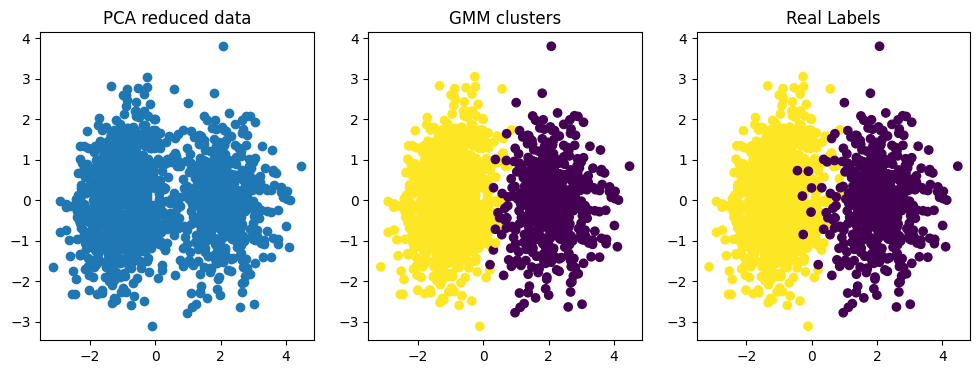

In [55]:
pca = PCA(n_components=2)  # We reduce to 2D with PCA for easy visualization
X_pca = pca.fit_transform(X)

# Predict the cluster for each data point
y_gmm = gmm.predict(X)

# Plot the clusters in the reduced dimensional space
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')
ax1.set_title('PCA reduced data')

ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_gmm, cmap='viridis')
ax2.set_title('GMM clusters')

ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
ax3.set_title('Real Labels')
plt.show()

Visually, the GMM looks to have done a good job of clustering the data. To get a better sense of how well it has clustered real and fake, well create an accuracy metric that measure how much the True Labels match the Predicted Clusters.

In [60]:
y_gmm_bool = y_gmm.astype(bool)  #match the data type of y_gmm to y

correct = 0
incorrect = 0

for i in range(len(y_gmm_bool)):
    if y_gmm_bool[i] == y[i]:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect)

print(f'accuracy: {accuracy} \n')
print(f'correct: {correct}')
print(f'incorrect: {incorrect}')

accuracy: 0.9917976760082023 

correct: 1451
incorrect: 12


99.18 percent of the data points are correctly clustered. This is a good sign that the GMM is working well. 

Inspecting the plot once more it seems the confusion is happening where the two gaussians mesh together in the middle. This is to be expected as the two gaussians are very close together.